# Task 2 - Generation

### Setting up dataset

Same as task 1, just seperating into train/val/test partitions.
Note: You don't have to run this, it is already present in dataset/task2

In [ ]:
# import os
# import shutil

# from general import WORD_LIST
# import random


# source_dir = 'dataset/easy'
# destination_dir = 'dataset/task2'

# if os.path.exists(destination_dir):
#     shutil.rmtree(destination_dir)

# os.makedirs(destination_dir, exist_ok=True)
# os.makedirs(os.path.join(destination_dir, 'train'), exist_ok=True)
# os.makedirs(os.path.join(destination_dir, 'val'), exist_ok=True)
# os.makedirs(os.path.join(destination_dir, 'test'), exist_ok=True)


# for filename in os.listdir(source_dir):
#     if filename.endswith('.png'):
#         parts = filename.split('_')
#         word = parts[0].lower()

#         new_dir = os.path.join(destination_dir, 'train', word)
#         os.makedirs(new_dir, exist_ok=True)
#         shutil.copy(os.path.join(source_dir, filename), os.path.join(new_dir, f'easy_{parts[1]}'))


# source_dir = 'dataset/hard'

# for filename in os.listdir(source_dir):
#     if filename.endswith('.png'):
#         parts = filename.split('_')
#         word = parts[0].lower()
        
#         category = random.choices(population=['train', 'val', 'test'], weights=[0.7, 0.2, 0.1], k=1)[0]
#         new_dir = os.path.join(destination_dir, category, word)
#         os.makedirs(new_dir, exist_ok=True)

#         shutil.copy(os.path.join(source_dir, filename), os.path.join(new_dir, f"hard-{parts[1]}-{parts[2]}-{parts[3]}-{parts[4]}"))

In [3]:
!ls dataset/task2/train | wc -l
!ls dataset/task2/val | wc -l
!ls dataset/task2/test | wc -l

!tree dataset/task2/train | wc -l
!tree dataset/task2/val | wc -l
!tree dataset/task2/test | wc -l

     608
     608
     608
  109118
   31218
   15929


The training dataset has about 110k samples, the val dataset has 31k and the test dataset has 16k (no overlap).

Let's now prepare a custom dataset where we encode the labels with `<SOS>`, `<EOS>`, and `PAD` tokens.

In [1]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from tqdm import tqdm

class dataset(Dataset):
    def __init__(self, root_dir, char2idx, transform=None):
        """
            Initialize the dataset.
            root_dir: The root directory containing the dataset.
            char2idx: A dictionary mapping characters to indices.
            transform: A torchvision transform to apply to the images.
        """
        
        self.root_dir = root_dir
        self.transform = transform
        self.char2idx = char2idx
        self.samples = []
        

        for label in os.listdir(root_dir):
            label_path = os.path.join(root_dir, label)

            if os.path.isdir(label_path):
                for file in os.listdir(label_path):
                    self.samples.append((os.path.join(label_path, file), label))
    

    def encode_label(self, label):
        """
            Encode the label string into a list of indices.
            Format: [<SOS>] + [characters...] + [<EOS>]
        """

        encoded = [self.char2idx['<SOS>']]

        for char in label:
            if char in self.char2idx:
                encoded.append(self.char2idx[char])

        encoded.append(self.char2idx['<EOS>'])

        return torch.tensor(encoded, dtype=torch.long)
    

    def __len__(self):
        return len(self.samples)
    

    def __getitem__(self, idx):
        image_path, label = self.samples[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label_encoded = self.encode_label(label)
        return image, label_encoded


def collate_fn(data):
    """
        Pad the labels to the maximum length in the batch.
        Allows for efficient batching while training, doesn't affect variable-length recognition.
    """

    images, sequences = zip(*data)
    images = torch.stack(images, 0)
    length = [seq.size(0) for seq in sequences]
    max_length = max(length)

    padded_sequences = torch.zeros(len(sequences), max_length, dtype=torch.long)

    for i, seq in enumerate(sequences):
        padded_sequences[i, :seq.size(0)] = seq

    return images, padded_sequences, length

### Encoder Module

Now, we can define the encoder module. The encoder uses a CNN to extract feature maps from the image. The feature maps are then reshaped so that the width is the sequence length.

In [2]:
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self):
        """
            Initialize the encoder model.

            Slightly different CNN architecture from the previous task, more spatial information is retained.

            Input: (batch, 3, 100, 250)
            Layer 1 output: (batch, 64, 50, 125)
            Output: (batch, 128, 25, 62)
        """

        super(Encoder, self).__init__()
            
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
    

    def forward(self, x):
        features = self.cnn(x)
        batch_size, channels, H, W = features.size()
        features = features.view(batch_size, channels * H, W).permute(0, 2, 1)
        return features

### Attention Module

We can now define the attention module. Adding an attention module allows the decoder to dynamically focus on different parts of the encoder's outputs (the feature maps) at each decoding step. 

**Bahdanau Attention:** Rather than compressing the encoder features into a single fixed vector, the attention mechanism computes a context vector (weighted sum) based off the encoder output. The attention scores are computed by comparing the current decoder hidden state iwth each encoder feature. The encoder outputs and the decoder state are mapped into a common "attention space" using linear layers. 

In [3]:
class Attention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        """
            Initialize the attention mechanism.

            encoder_dim: Dimensionality of the encoder output (e.g., channels * height).
            decoder_dim: Hidden size of the decoder.
            attention_dim: Size of the intermediate attention space.
        """
        
        super(Attention, self).__init__()

        self.encoder_att = nn.Linear(encoder_dim, attention_dim)     # Project encoder output into attention space dimension
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)     # Project decoder output into attention space dimension

        self.full_att = nn.Linear(attention_dim, 1)                  # Reduces combined features into a single scalar score for each timestep 

        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
    

    def forward(self, encoder_out, decoder_hidden):
        """
        Inputs:
            encoder_out: Tensor of shape (batch, seq_len, encoder_dim)
            decoder_hidden: Tensor of shape (batch, decoder_dim)
        Outputs:
            context: Weighted sum over encoder outputs (batch, encoder_dim)
            alpha: Attention weights (batch, seq_len)
        """

        enc_att = self.encoder_att(encoder_out)                     # (batch, seq_len, attention_dim)
        dec_att = self.decoder_att(decoder_hidden).unsqueeze(1)     # (batch, 1, attention_dim)

        att = self.relu(enc_att + dec_att)

        att = self.full_att(att).squeeze(2)                         # (batch, seq_len)

        alpha = self.softmax(att)                                   # (batch, seq_len)

        context = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)     # (batch, seq_len, encoder_dim) * (batch, seq_len, 1) => sum => (batch, encoder_dim)

        return context, alpha

### Decoder Module

Decoder is responsible for converting the encoded image features into a sequence of output tokens, one time step at a time.

For each timestep (position in output sequence), there are six main steps:
- Token embedding: The current input token (starting with `<SOS>`) is converted into a embedding vector
- Attention mechansism: Context vector is retrieved from attention module
- Gating: A gating mechanisms controls the flow of information, using the decoder hidden state to scale the context vector
- LSTM Update: The token embedding & gated context vector are concatenated and passed into an LSTM cell.
- Output prediction: The updated hidden state is then used to predict the next token via a linear layer to the vocabulary
- Teacher forcing: The module may use the "true" next token (from the label) as the input for the following timestep rather than the predicted token.

The final output is a sequence of predictions for each timestep.

In [4]:
class DecoderRNN(nn.Module):
    def __init__(self, attention_dim, embed_dim, decoder_dim, vocab_size, encoder_dim, dropout=0.5):
        """
            Initialize the decoder model.

            attention_dim: Size of the attention layer.
            embed_dim: Dimension of the token embeddings.
            decoder_dim: Hidden size of the LSTM decoder.
            vocab_size: Number of tokens in the vocabulary.
            encoder_dim: Dimension of the encoder output.
            dropout: Dropout rate.
        """

        super(DecoderRNN, self).__init__()
        
        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)
        
        self.embedding = nn.Embedding(vocab_size, embed_dim)

        self.dropout = nn.Dropout(dropout)

        # The LSTM cell takes concatenated [embedding & context]
        self.decode_step = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim, bias=True)

        # Initial hidden and cell states are computed from the mean encoder output.
        self.init_h = nn.Linear(encoder_dim, decoder_dim)
        self.init_c = nn.Linear(encoder_dim, decoder_dim)

        # Gating mechanism to modulate the attention context.
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)
        self.sigmoid = nn.Sigmoid()

        # Final output layer: project decoder hidden state to vocabulary logits.
        self.fc = nn.Linear(decoder_dim, vocab_size)
        self.vocab_size = vocab_size

    
    def init_hidden_state(self, encoder_out):
        """
            Initialize the hidden and cell states of the LSTM cell.
        """

        # Compute the mean encoder output across the sequence length
        mean_encoder_out = encoder_out.mean(dim=1)

        h = self.init_h(mean_encoder_out)  # (batch, decoder_dim)
        c = self.init_c(mean_encoder_out)

        return h, c
    
    
    def forward(self, encoder_out, encoded_captions, caption_lengths, teacher_forcing_ratio=0.5):
        """
        Inputs:
            encoder_out: (batch, seq_len, encoder_dim)
            encoded_captions: (batch, max_caption_length) with <SOS> as the first token.
            caption_lengths: List of caption lengths (can be used for masking, if needed).
            teacher_forcing_ratio: Probability of using the ground truth token as the next input.
        Output:
            outputs: Tensor of shape (batch, max_caption_length - 1, vocab_size) containing the logits for each time step.
        """

        batch_size = encoder_out.size(0)
        max_caption_length = encoded_captions.size(1)

        h, c = self.init_hidden_state(encoder_out)                      # (batch, decoder_dim)

        outputs = torch.zeros(batch_size, max_caption_length - 1, self.vocab_size).to(encoder_out.device)

        # Start with the <SOS> token for every example in the batch.
        input_token = encoded_captions[:, 0]                            # (batch)
        
        for t in range(max_caption_length - 1):
            # Get embedding for the current token.
            embedding_input = self.embedding(input_token)               # (batch, embed_dim)

            # Compute attention to obtain context vector.
            context, alpha = self.attention(encoder_out, h)             # (batch, encoder_dim), (batch, seq_len)

            # Apply gating on the context vector.
            gate = self.sigmoid(self.f_beta(h))
            context = gate * context                

            # Concatenate the embedding and context and pass through the LSTM cell.
            lstm_input = torch.cat([embedding_input, context], dim=1)   # (batch, embed_dim + encoder_dim)
            
            # Update the hidden state and cell state.
            h, c = self.decode_step(lstm_input, (h, c))

            preds = self.fc(self.dropout(h))                            # (batch, vocab_size)
            
            # Update logits for current time step
            outputs[:, t, :] = preds    

            # Decide whether to use teacher forcing.
            teacher_force = torch.rand(1).item() < teacher_forcing_ratio
            input_token = encoded_captions[:, t+1] if teacher_force else preds.argmax(1)

        return outputs

### Putting everything together

We have all the ingredients ready, now we can start making the dish. Let's first define the general model.

In [5]:
class CaptchaModel(nn.Module):
    def __init__(self, encoder, decoder):
        """
            Initialize the end-to-end model.
        """

        super(CaptchaModel, self).__init__()

        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, images, captions, caption_lengths, teacher_forcing_ratio=0.5):
        """
        Inputs:
            images: (batch, 3, 100, 250)
            captions: (batch, max_caption_length)
            caption_lengths: List of caption lengths.
            teacher_forcing_ratio: Probability of using the ground truth token as the next input.
        """

        encoder_out = self.encoder(images)
        outputs = self.decoder(encoder_out, captions, caption_lengths, teacher_forcing_ratio)

        return outputs

Now we can define a training loop, evaluate loop, and some performance metrics:

In [6]:
import torch.optim as optim

def levenshtein_distance(seq1, seq2):
    """
        Compute the Levenshtein distance between two sequences.
    """

    m, n = len(seq1), len(seq2)
    dp = [[0] * (n + 1) for _ in range(m + 1)]

    for i in range(m + 1):
        dp[i][0] = i

    for j in range(n + 1):
        dp[0][j] = j

    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if seq1[i - 1] == seq2[j - 1]:
                dp[i][j] = dp[i - 1][j - 1]
            else:
                dp[i][j] = 1 + min(dp[i - 1][j], dp[i][j - 1], dp[i - 1][j - 1])

    return dp[m][n]


def decode_sequence(seq, idx2char):
    """
        Decodes a sequence of indices into a string.
        Ignores PAD tokens (index 0) and <SOS>.
        Stops decoding when encountering <EOS>.
    """

    out = []
    for idx in seq:
        if idx == 0:  # PAD token
            continue
        char = idx2char.get(idx, '')
        if char == '<SOS>':
            continue
        if char == '<EOS>':
            break
        out.append(char)

    return ''.join(out)


def compute_batch_wer(outputs, targets, idx2char):
    """
        Computes the average normalized edit distance (WER) for a batch.
        For each sample, the edit distance is computed between the decoded prediction and target, and normalized by the length of the target word.
    """
    
    _, preds = torch.max(outputs, dim=2)  # (batch, seq_len)

    total_wer = 0.0
    batch_size = preds.size(0)

    for i in range(batch_size):
        pred_seq, target_seq = preds[i].tolist(), targets[i].tolist()

        pred_word, target_word = decode_sequence(pred_seq, idx2char), decode_sequence(target_seq, idx2char)

        # Compute character-level edit distance as a proxy for WER.
        distance = levenshtein_distance(list(target_word), list(pred_word))

        sample_wer = distance / max(len(target_word), 1)  # normalized per sample
        total_wer += sample_wer

    return total_wer / batch_size if batch_size > 0 else 0.0


def compute_word_accuracy(outputs, targets, idx2char):
    """
        Computes word-level accuracy for a batch.
    """
    
    _, preds = torch.max(outputs, dim=2)
    batch_size = preds.size(0)

    correct = 0

    for i in range(batch_size):
        pred_seq = preds[i].tolist()
        target_seq = targets[i].tolist()

        pred_word, target_word = decode_sequence(pred_seq, idx2char), decode_sequence(target_seq, idx2char)

        if pred_word == target_word:
            correct += 1

    return correct / batch_size if batch_size > 0 else 0.0


def evaluate(model, val_loader, idx2char, device="cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu", pad_idx=0):
    model.eval() 

    total_loss = 0.0
    total_wer = 0.0
    total_accuracy = 0.0

    criterion = nn.CrossEntropyLoss(ignore_index=0)  # Ignore PAD tokens.

    with torch.no_grad():
        for images, captions, lengths in tqdm(val_loader):
            images, captions = images.to(device), captions.to(device)

            # Use teacher_forcing_ratio=0 during evaluation.
            outputs = model(images, captions, lengths, teacher_forcing_ratio=0.0)

            # Targets: remove the <SOS> token (first token).
            targets = captions[:, 1:]

            # Reshape outputs and targets for loss calculation.
            outputs_reshaped = outputs.view(-1, model.decoder.vocab_size)
            targets_reshaped = targets.contiguous().view(-1)

            loss = criterion(outputs_reshaped, targets_reshaped)
            total_loss += loss.item()

            batch_wer = compute_batch_wer(outputs, targets, idx2char)
            total_wer += batch_wer

            batch_accuracy = compute_word_accuracy(outputs, targets, idx2char)
            total_accuracy += batch_accuracy


    avg_loss = total_loss / len(val_loader)
    avg_wer = total_wer / len(val_loader)
    avg_accuracy = total_accuracy / len(val_loader)

    return avg_loss, avg_wer, avg_accuracy


def train(model, train_loader, val_loader, idx2char, num_epochs=20, learning_rate=1e-4, device="cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu", pad_idx=0):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss(ignore_index=0)  # PAD token is 0.
    
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()

        total_train_loss = 0.0
        total_wer_loss = 0.0

        for images, captions, lengths in tqdm(train_loader):
            images, captions = images.to(device), captions.to(device)
            optimizer.zero_grad()
            
            outputs = model(images, captions, lengths, teacher_forcing_ratio=0.5)
            
            # Exclude the <SOS> token from targets.
            targets = captions[:, 1:]

            # Reshape outputs and targets for loss computation.
            outputs_reshaped = outputs.view(-1, model.decoder.vocab_size)
            targets_reshaped = targets.contiguous().view(-1)
            
            loss = criterion(outputs_reshaped, targets_reshaped)
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()

            batch_wer = compute_batch_wer(outputs, targets, idx2char)
            total_wer_loss += batch_wer

        
        avg_train_loss = total_train_loss / len(train_loader)
        avg_train_wer = total_wer_loss / len(train_loader)
        avg_val_loss, avg_val_wer, avg_val_acc = evaluate(model, val_loader, idx2char, device, pad_idx=pad_idx)
        
        print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.4f}, Train WER: {avg_train_wer:.4f} | Val Loss: {avg_val_loss:.4f}, Val WER: {avg_val_wer:.4f}, Val Accuracy: {avg_val_acc:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': avg_val_loss,
            }
            torch.save(checkpoint, f'best_model_checkpoint_{num_epochs}.pth')
            print(f"Checkpoint saved at epoch {epoch+1} with val_loss: {avg_val_loss:.4f}")

Defining hyperparameters and putting it all together:

Explanation of some choices:
- `embed_dim = 256` offers a balanced representation, sufficient detail without overly increasing complexity
- `decoder_dim = 512` higher than embed_dim to provide LSTM with rich state space
- `attention_dim = 256` good balance to learn alignment between encoder features and decoder's state

In [7]:
if __name__ == "__main__":
    
    # Create mapping from characters to indices.

    characters = "abcdefghijklmnopqrstuvwxyz"
    char2idx = {c: idx+1 for idx, c in enumerate(characters)}  # 0 is reserved for the PAD token.
    char2idx['<SOS>'] = len(char2idx) + 1
    char2idx['<EOS>'] = len(char2idx) + 1
    vocab_size = len(char2idx) + 1  # +1 for the PAD token at index 0

    idx2char = {idx: char for char, idx in char2idx.items()}

    transform = transforms.Compose([
        transforms.Resize((100, 250)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])


    # Load the dataset.

    print("Loading datasets...")

    data_folder = 'dataset/task2_600'

    train_dataset = dataset(root_dir=f"{data_folder}/train", char2idx=char2idx, transform=transform)
    val_dataset = dataset(root_dir=f"{data_folder}/val", char2idx=char2idx, transform=transform)
    test_dataset = dataset(root_dir=f"{data_folder}/test", char2idx=char2idx, transform=transform)
    
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

    print("Datasets loaded.")
    print(f"Dataset sizes: Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")


    # Initialize the model.

    encoder = Encoder()

    decoder = DecoderRNN(
        attention_dim=256,
        embed_dim=256,
        decoder_dim=512,
        vocab_size=vocab_size,
        encoder_dim=128 * 25,  # encoder_dim = channels * H (here 128 * 25)
        dropout=0.5
    )

    model = CaptchaModel(encoder, decoder)
    
    device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
    print(f"Using device: {device}")
    train(model, train_loader, val_loader, idx2char=idx2char, num_epochs=50, learning_rate=1e-4, device=device, pad_idx=0)


Loading datasets...
Datasets loaded.
Dataset sizes: Train: 108644, Val: 30629, Test: 15159
Using device: mps


  0%|          | 11/6791 [00:01<14:58,  7.54it/s] 


KeyboardInterrupt: 

### Testing the model

Now, we can use the generated model file to run check the WER on the test dataset:

In [8]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

checkpoint = torch.load(f'models/generation_complete_prev-arc_prev-data.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

test_loss, test_wer, test_acc = evaluate(model, test_loader, idx2char, device=device, pad_idx=0)
print(f"Test Loss: {test_loss:.4f}, Test WER: {test_wer:.4f}, Test Accuracy: {test_acc:.4f}")

100%|██████████| 948/948 [00:40<00:00, 23.56it/s]

Test Loss: 0.0684, Test WER: 0.0150, Test Accuracy: 0.9643


That's really good WER & accuracy! Looking at it sample by sample:

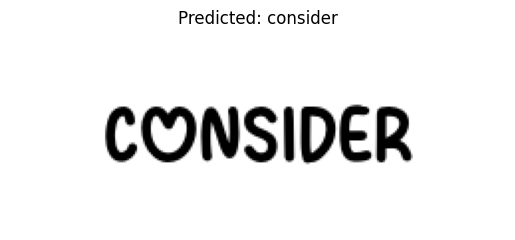

In [15]:
import random
import matplotlib.pyplot as plt

def unnormalize(tensor, mean, std):
    """
        Reverses the normalization of an image tensor.
    """

    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor


random_index = random.randint(0, len(test_dataset) - 1)
image, label = test_dataset[random_index]

to_pil = transforms.ToPILImage()
image_pil = to_pil(unnormalize(image.clone(), [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]))

img_tensor = image.unsqueeze(0).to(device)

# For inference, we supply a dummy caption that starts with <SOS> token.
# The model will predict the next token and use it as input for the next timestep.

sos_idx = char2idx['<SOS>']
max_len = 15

dummy_caption = torch.zeros(1, max_len, dtype=torch.long).to(device)
dummy_caption[0, 0] = sos_idx


model.eval()
with torch.no_grad():
    outputs = model(img_tensor, dummy_caption, [max_len], teacher_forcing_ratio=0.0)
    _, preds = torch.max(outputs, dim=2)
    predicted_sequence = preds[0].tolist()


predicted_text = decode_sequence(predicted_sequence, idx2char)

plt.imshow(image_pil)
plt.title(f"Predicted: {predicted_text}")
plt.axis('off')
plt.show()



## Experiments

With the model created and working, I wanted to do a few experiments.

First off, let's check what a random baseline gives us.

Let's give randomness the benefit of the doubt and assume that it knows how many tokens it has to generate every time.

In [55]:
def evaluate_random_variable_length(val_loader, idx2char, vocab_size, device="cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"):
    """
        Evaluates loss, WER, and word accuracy using random predictions.
        For each sample, the random prediction has a length equal to the target label's length.
        Assumes that `lengths` contains the original caption lengths including <SOS>.
        Thus, the effective target length is lengths[i] - 1.
    """

    total_loss = 0.0
    total_wer = 0.0
    total_accuracy = 0.0
    total_length_acc = 0.0

    total_samples = 0
    criterion = nn.CrossEntropyLoss(ignore_index=0)  # Ignore PAD tokens.

    with torch.no_grad():
        for images, captions, lengths in tqdm(val_loader):
            captions = captions.to(device)

            # Remove the <SOS> token. Note: targets is padded to a fixed max length.
            targets = captions[:, 1:]
            batch_size = captions.size(0)
            
            for i in range(batch_size):
                target_length = lengths[i] - 1
                
                # Generate a random prediction tensor for this sample of shape (target_length, vocab_size)
                random_output = torch.randn(target_length, vocab_size, device=device)
                
                # Extract the corresponding ground truth target tokens for this sample.
                target_sample = targets[i, :target_length]
                
                loss = criterion(random_output, target_sample)
                total_loss += loss.item()

                pred_indices = torch.argmax(random_output, dim=1).tolist()
                target_indices = target_sample.tolist()
                pred_word = decode_sequence(pred_indices, idx2char)
                target_word = decode_sequence(target_indices, idx2char)
                
                distance = levenshtein_distance(list(target_word), list(pred_word))
                sample_wer = distance / max(len(target_word), 1)
                total_wer += sample_wer
            
                if pred_word == target_word:
                    total_accuracy += 1

                if len(pred_word) == len(target_word):
                    total_length_acc += 1
                
                total_samples += 1


    avg_loss = total_loss / total_samples if total_samples > 0 else 0.0
    avg_wer = total_wer / total_samples if total_samples > 0 else 0.0
    avg_accuracy = total_accuracy / total_samples if total_samples > 0 else 0.0

    return avg_loss, avg_wer, avg_accuracy


random_loss, random_wer, random_acc = evaluate_random_variable_length(test_loader, idx2char, vocab_size, device=device)
print(f"Random Loss: {random_loss:.4f}, Random WER: {random_wer:.4f}, Random Accuracy: {random_acc:.4f}")

100%|██████████| 948/948 [00:17<00:00, 52.97it/s]

Random Loss: 3.8405, Random WER: 1.0137, Random Accuracy: 0.0000


Wow! That's horrible!

Now, the model was only trained on 600 common words from the English dictionary. I'm curious as to what would happen if I gave it completely random sequences of letters as an image. Let's first generate a small dataset.

In [59]:
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import os
import random

# Same generation template as Task 0.

IMAGE_SIZE = (250, 100)
FONT_FOLDER = "fonts"
EXCLUDE_FOLDER = "dataset/exclude/samples"
SAMPLES = 1000

font_files = os.listdir(FONT_FOLDER)
text_colors = ["black", "red", "green", "blue", "purple", "orange", "pink", "brown"]


def random_capitalization(word):
    return ''.join(char.upper() if random.random() < 0.4 else char.lower() for char in word)


def create_base_image(word, font_path, bg_color="white", text_color="black", font_size=30):
    """
        Creates an image given a word, font path, background color, text color and font size.
    """
    img = Image.new("RGB", IMAGE_SIZE, color=bg_color)
    draw = ImageDraw.Draw(img)

    # Try loading font
    try:
        font = ImageFont.truetype(font_path, font_size)
    except IOError:
        print(f"Cannot load font {font_path}, using default")
        font = ImageFont.load_default()
    

    # Calculate text size and center it

    text_width = draw.textlength(word, font)
    text_height = font_size
    text_x = (IMAGE_SIZE[0] - text_width) // 2
    text_y = (IMAGE_SIZE[1] - text_height) // 2

    draw.text((text_x, text_y), word, font=font, fill=text_color)

    return img


def add_noise(image, noise_level):
    """
        Adds Gaussian noise to the image.
    """

    arr = np.array(image)
    noise = np.random.normal(0, noise_level, arr.shape)
    noisy_arr = np.clip(arr + noise, 0, 255)

    return Image.fromarray(noisy_arr.astype(np.uint8))


if os.path.exists(EXCLUDE_FOLDER):
    for root, dirs, files in os.walk(EXCLUDE_FOLDER, topdown=False):
        for name in files:
            os.remove(os.path.join(root, name))
        for name in dirs:
            os.rmdir(os.path.join(root, name))

os.makedirs(EXCLUDE_FOLDER, exist_ok=True)

for i in range(1, SAMPLES + 1):
    word_length = random.randint(4, 12)
    word = ''.join(random.choice("abcdefghijklmnopqrstuvwxyz") for _ in range(word_length))
    word = random_capitalization(word)
    
    text_color = random.choice(text_colors)

    font_file = random.choice(font_files)
    font_path = os.path.join(FONT_FOLDER, font_file)

    os.makedirs(f"{EXCLUDE_FOLDER}/{word.lower()}", exist_ok=True)

    img = create_base_image(word, font_path, text_color=text_color, font_size=30)
    img = add_noise(img, random.randint(0, 20))
    img.save(f"{EXCLUDE_FOLDER}/{word.lower()}/{i}.png")  


Now, we can test the model on the new dataset.

In [9]:
EXCLUDE_FOLDER = "dataset/exclude/samples"
exclude_dataset = dataset(root_dir=EXCLUDE_FOLDER, char2idx=char2idx, transform=transform)
exclude_loader = DataLoader(exclude_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

checkpoint = torch.load(f'models/generation_complete_prev-arc_prev-data.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

exclude_loss, exclude_wer, exclude_acc = evaluate(model, exclude_loader, idx2char, device=device, pad_idx=0)
print(f"Exclude Loss: {exclude_loss:.4f}, Exclude WER: {exclude_wer:.4f}, Exclude Accuracy: {exclude_acc:.4f}")

100%|██████████| 63/63 [00:02<00:00, 24.56it/s]

Exclude Loss: 10.7684, Exclude WER: 0.8708, Exclude Accuracy: 0.0000


Really bad results. Looking at it sample by sample:

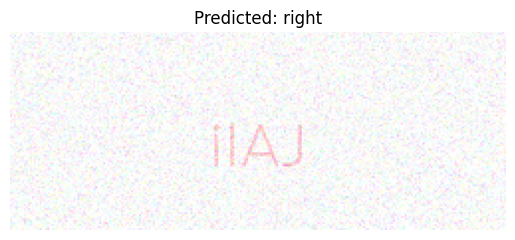

In [64]:
import random
import matplotlib.pyplot as plt

random_index = random.randint(0, len(exclude_dataset) - 1)
image, label = exclude_dataset[random_index]

to_pil = transforms.ToPILImage()
image_pil = to_pil(unnormalize(image.clone(), [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]))

img_tensor = image.unsqueeze(0).to(device)

sos_idx = char2idx['<SOS>']
max_len = 15

dummy_caption = torch.zeros(1, max_len, dtype=torch.long).to(device)
dummy_caption[0, 0] = sos_idx


model.eval()
with torch.no_grad():
    outputs = model(img_tensor, dummy_caption, [max_len], teacher_forcing_ratio=0.0)
    _, preds = torch.max(outputs, dim=2)
    predicted_sequence = preds[0].tolist()


predicted_text = decode_sequence(predicted_sequence, idx2char)

plt.imshow(image_pil)
plt.title(f"Predicted: {predicted_text}")
plt.axis('off')
plt.show()

It feels like the model has learnt some connections between english alphabets, and is now struggling to recognise completely random sequences of letters.

Let's see how it performs if we provide it with random words one at a time:

Confidence: [0.8976112604141235, 0.7801320552825928, 0.9997304081916809, 0.7391104102134705, 0.7738238573074341, 0.9999949932098389, 0.9999988079071045, 0.9999998807907104, 0.999998927116394, 0.9999994039535522, 0.9999992847442627, 0.9999998807907104, 0.9999998807907104, 0.9999998807907104]


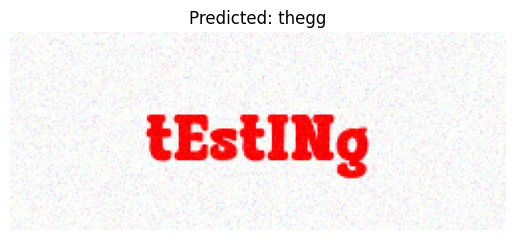

In [58]:
word = "testing"

word = random_capitalization(word)
text_color = random.choice(text_colors)
font_file = random.choice(font_files)
font_path = os.path.join(FONT_FOLDER, font_file)

img = create_base_image(word, font_path, text_color=text_color, font_size=30)
noise_level = random.randint(0, 20)
img = add_noise(img, noise_level)

img_tensor = transform(img).unsqueeze(0).to(device)
model.eval()

with torch.no_grad():
    outputs = model(img_tensor, dummy_caption, [max_len], teacher_forcing_ratio=0.0)
    _, preds = torch.max(outputs, dim=2)
    predicted_sequence = preds[0].tolist()
    confidence = torch.softmax(outputs, dim=2).max(dim=2)[0][0].tolist()
    print(f"Confidence: {confidence}")

predicted_text = decode_sequence(predicted_sequence, idx2char)

plt.imshow(img)
plt.title(f"Predicted: {predicted_text}")
plt.axis('off')
plt.show()

This doesn't seem to be the case.

I considered the fact that the model might be overfitting, but when testing with the same architecture trained for less epochs, I see the same behaviour.

I feel this must be because the training samples have only 600 possible words, which isn't really much. The way I had designed my training data is such that each word has many different permutations in terms of size, font, noise, etc. This was beneficial for task 1, where for each of the 100 classes I had many many samples. However, this task requires a different approach. 

[New attempt.](/CaptchaRecognition/task-2_generation.ipynb)